<a href="https://colab.research.google.com/github/maicon-reis/financas_quantitativas/blob/main/Aplica_Diferencia%C3%A7%C3%A3o_Fracion%C3%A1ria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Funções Utilizadas**

In [ ]:
# Função que calcula o array de pesos para a Diferenciação Fracionária
def calcula_pesos(d, lim = 0.01): # Lim exclui pesos insignificantes
        w = [1.]
        k = 1
        while abs(w[-1]) >= lim:
            w_ = -w[-1] / k * (d - k + 1)
            w.append(w_)
            k += 1
        w = np.array(w[::-1]).reshape(-1, 1)[1:]
        return w

# Função que aplica a array de pesos sobre a base de dados original
def fracDiff(series, d, lim=0.01):
    w = calcula_pesos(d, lim)
    tam = len(w) - 1
    df = {}
    for nome in series.columns:
        seriesF = series[[nome]].fillna(method = 'ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(tam, seriesF.shape[0]):
            loc0 = seriesF.index[iloc1 - tam]
            loc1 = seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, nome]):
                continue
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0 : loc1])[0, 0]
        df[nome] = df_.copy(deep = True)
    df = pd.concat(df, axis = 1)
    return df

# Função que calcula o menor fator de diferenciação fracionária
def det_min_d(series, lim=0.01):
    res = pd.DataFrame(columns = ['adfStat', 'pVal', 'lags', 'nObs'
                                , '95% conf', 'corr'])
        
    for d in np.linspace(0, 1, 11):
        df1 = np.log(series) #.resample('1D').last()
        df2 = fracDiff(df1, d, lim)
        corr = np.corrcoef(df1.loc[df2.index, "Adj Close"]
                           , df2["Adj Close"])[0, 1]
        adf = adfuller(df2['Adj Close'], maxlag = 1, regression = 'c'
                        , autolag = None)
        res.loc[d] = list(adf[ : 4]) + [adf[4]['5%']] + [corr]
        
    min_d = res[res['pVal'] < 0.05].index[0]
    return res, min_d

# Funçao que faz o cálculo do zscore para reduzir a heterocedasticidade
def reduz_heterocedasticiade(df):
    v = list()
    ret_desvios = [1]
    v.append(abs(df['log_ret_diff'].iloc[0]))
    for i in range(1,len(df['log_ret_diff'])):
        v.append(np.sqrt(0.94*v[-1]*v[-1] + (1-0.94) * df['log_ret_diff'].iloc[i] * df['log_ret_diff'].iloc[i]))
        ret_desvios.append((df['log_ret_diff'].iloc[i]-sum(df['log_ret_diff'].iloc[0:i])/len(df['log_ret_diff'].iloc[0:i]))/v[i-1])
    df['log_ret_diff'] = ret_desvios
    return df

# criando função para realizar o teste de adfuler
def teste_adfuller(data):
    resultados = adfuller(data, maxlag = 1, regression = 'c', autolag = None)
    rotulos    = ['Teste estatístico ADF', 'p-value', '#lags', 'no de observações usadas']
    
    for valor, rotulo in zip(resultados, rotulos):
        print('{}: {}'.format(rotulo, valor))
    
    if resultados[1]>0.05:
        print('Falhou em rejeitar a hipótese nula, os dados são NÃO ESTACIONÁRIOS.')
    else:
        print('Rejeitamos a hipótese nula, os dados são ESTACIONÁRIOS.')
    
    return None

In [ ]:
# Importando a base de dados
csv_file = "https://raw.githubusercontent.com/maicon-reis/financas_quantitativas/main/arquivos/ibov-2000_2021"

# Criando um dataframe
df = pd.read_csv(csv_file, usecols=["Date", "Open", "High", "Low", "Close", "Adj Close"])

# Modificando o formato da data
pd.to_datetime(df["Date"])

# Configurando a data como índice
df.set_index("Date", inplace=True)

# Verificando a base de dados
df.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2000-01-03,17098.0,17408.0,16719.0,16930.0,16930.0
2000-01-04,16908.0,16908.0,15851.0,15851.0,15851.0
2000-01-05,15871.0,16302.0,15350.0,16245.0,16245.0
2000-01-06,16237.0,16499.0,15977.0,16107.0,16107.0
2000-01-07,16125.0,16449.0,16125.0,16309.0,16309.0


In [ ]:
# Calculando o menor fator de diferenciação fracionária
out, min_d = det_min_d(df[['Adj Close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
# Transformando a base de dados com o fator de diferenciação fracionário
df['log_ret_frac'] = fracDiff(df[['Adj Close']], min_d)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
# Transformando a base de dados com o fator de diferenciação inteiro
d = 1
df['log_ret_int'] = np.log(df['Adj Close']).diff(d)

In [ ]:
# Eliminando as linhas que contém elementos faltantes 
df.dropna(axis=0, inplace=True)

# Verificando dados
df.head()

,Open,High,Low,Close,Adj Close,log_ret_frac,log_ret_int
Date,,,,,,,
2000-01-17,17678.0,18099.0,17678.0,18053.0,18053.0,5345.464089,0.022123
2000-01-18,18062.0,18062.0,17625.0,17903.0,17903.0,4951.139458,-0.008344
2000-01-19,17905.0,18075.0,17470.0,17470.0,17470.0,4469.632402,-0.024483
2000-01-20,17487.0,17622.0,17029.0,17177.0,17177.0,4302.544726,-0.016914
2000-01-21,17188.0,17372.0,16901.0,17034.0,17034.0,4290.100295,-0.008360


In [ ]:
# Verificando a estacionariedade da base de dados com diferenciação fracionária
teste_adfuller(df['log_ret_frac'])

Teste estatístico ADF: -3.4609646405723904
p-value: 0.009048057482653936
#lags: 1
no de observações usadas: 5429
Rejeitamos a hipótese nula, os dados são ESTACIONÁRIOS.


In [ ]:
# Verificando a estacionariedade da base de dados com diferenciação inteira
teste_adfuller(df['log_ret_int'])

Teste estatístico ADF: -52.92899875102156
p-value: 0.0
#lags: 1
no de observações usadas: 5429
Rejeitamos a hipótese nula, os dados são ESTACIONÁRIOS.


Correlação entre Diferenciação Inteira e Fracionária com a Base de Dados Original

Diferenciação Inteira: 1.19%
Diferenciação Fracionária: 99.45%



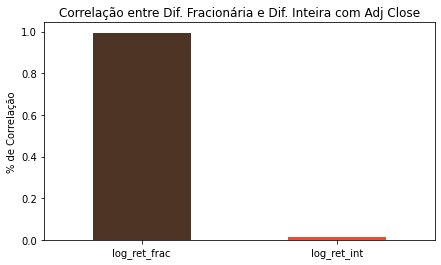

In [ ]:
df_ = df[['Adj Close', 'log_ret_frac', 'log_ret_int', ]]

print('Correlação entre Diferenciação Inteira e Fracionária com a Base de Dados Original')
print()
print('Diferenciação Inteira: {}%'.format(round(df_.corr()['Adj Close'][1:][1]*100, 2)))
print('Diferenciação Fracionária: {}%'.format(round(df_.corr()['Adj Close'][1:][0]*100, 2)))
print()

with plt.style.context("seaborn-deep"):
    cores = ['#4D3425','#E4512B']
    plt.figure(figsize=(7, 4))
    df_.corr()['Adj Close'][1:].plot(kind='bar', color = cores, stacked=True, rot=0)
    plt.title('Correlação entre Dif. Fracionária e Dif. Inteira com Adj Close')
    plt.ylabel('% de Correlação')

    total = []
    plt.show()

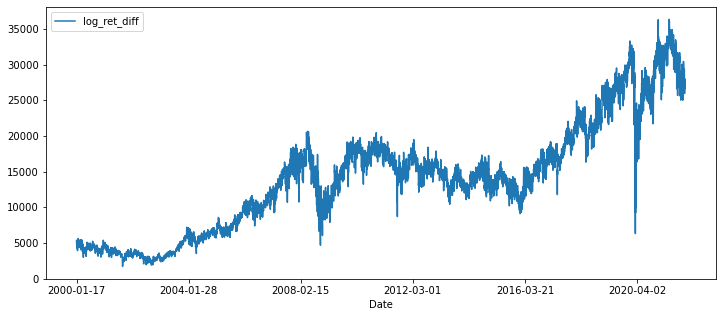

In [ ]:
df[['log_ret_diff']].plot(figsize=(12,5));

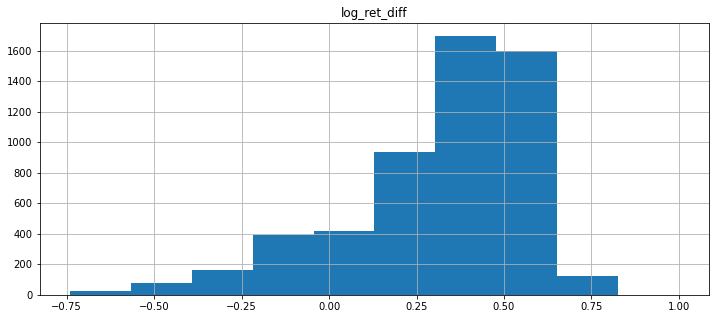

In [ ]:
df[['log_ret_diff']].hist(figsize=(12,5));

In [ ]:
# Reduzindo a heterocedasticidade com zscore
def reduz_heterocedasticiade(df):
    v = list()
    ret_desvios = [1]
    v.append(abs(df['log_ret_diff'].iloc[0]))
    for i in range(1,len(df['log_ret_diff'])):
        v.append(np.sqrt(0.94*v[-1]*v[-1] + (1-0.94) * df['log_ret_diff'].iloc[i] * df['log_ret_diff'].iloc[i]))
        ret_desvios.append((df['log_ret_diff'].iloc[i]-sum(df['log_ret_diff'].iloc[0:i])/len(df['log_ret_diff'].iloc[0:i]))/v[i-1])
    df['log_ret_diff'] = ret_desvios
    return df

In [ ]:
# Reduzindo a heterocedasticidade da base de dados com transformação fracionária
df = reduz_heterocedasticiade(df)

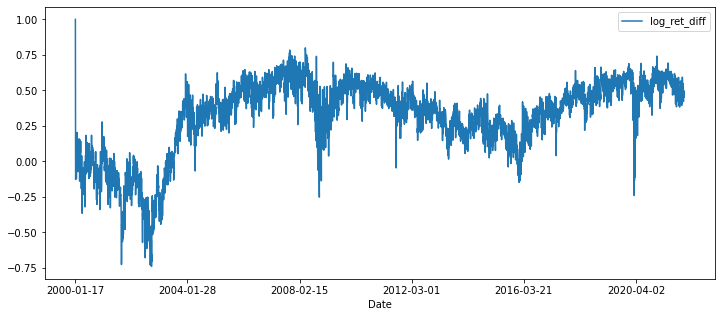

In [ ]:
# Visualizando o gráfico de retornos da diferenciação fracionária
df[['log_ret_diff']].plot(figsize=(12,5));

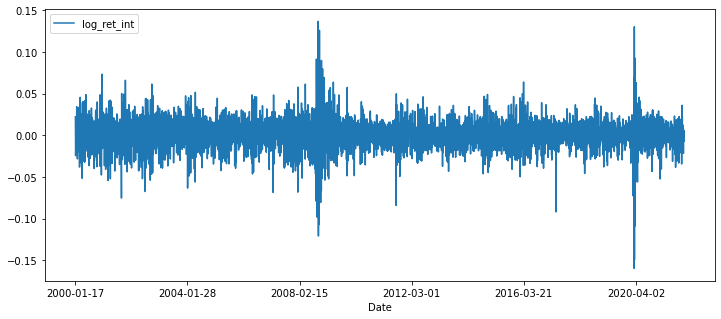

In [ ]:
# Visualizando o gráfico de retornos da diferenciação inteira
df[['log_ret_int']].plot(figsize=(12,5));